## Predicting Tree Growth Using 5 milliom Trees in the US





> for reference, follow the original source [<u>Readme.md</u>](https://github.com/MrDevel0per/bio-data-analysis/blob/main/README.md) for preprocessing if you want, else pip install [requirements.txt](../requirements.txt) and follow this.

#### Download Data from Kagglehub


In [2]:
import kagglehub
import os, shutil


# Download latest version
if not os.path.exists("mexwell/5m-trees-dataset"):
    download_path = kagglehub.dataset_download("mexwell/5m-trees-dataset")
    
    FILEPATH = os.path.join(os.path.pardir, 'mexwell/5m-trees-dataset')
    if not os.path.exists(FILEPATH):
        shutil.move(download_path, FILEPATH)
    print("Path to dataset files:", FILEPATH)
else:
    print('"mexwell/5m-trees-dataset" already exists')

Path to dataset files: ../mexwell/5m-trees-dataset


### Move to project directory

In [3]:
# Extract 'valid' csv files

files_list = sorted([file for file in os.listdir(FILEPATH) if file.endswith('.csv')])
print(f'Total files: {len(files_list)}\n')

csv_files = []

for file in files_list:
    file_path = os.path.join(FILEPATH, file)
    size = os.path.getsize(file_path) / 1024
    
    if os.path.relpath(file).endswith('.csv') and size > 10:
        csv_files.append(file_path)
        size /= 1024
        print(f'Added {file} | size: {round(size, 2)}MB')
        
print(f'\nTotal valid CSV files: {len(csv_files)}\n')

Total files: 64

Added Albuquerque_Final_2022-06-18.csv | size: 0.63MB
Added Anaheim_Final_2022-06-18.csv | size: 15.04MB
Added Arlington_Final_2022-06-18.csv | size: 2.39MB
Added Atlanta_Final_2022-06-18.csv | size: 7.34MB
Added AuroraCO_Final_2022-06-18.csv | size: 14.08MB
Added Austin_Final_2022-06-18.csv | size: 1.55MB
Added Baltimore_Final_2022-06-18.csv | size: 28.41MB
Added Boston_Final_2022-06-18.csv | size: 0.22MB
Added Buffalo_Final_2022-06-18.csv | size: 23.46MB
Added CapeCoral_Final_2022-06-18.csv | size: 7.61MB
Added ColoradoSprings_Final_2022-06-18.csv | size: 4.27MB
Added Columbus_Final_2022-06-18.csv | size: 34.6MB
Added Dallas_Final_2022-06-18.csv | size: 0.97MB
Added Denver_Final_2022-06-18.csv | size: 67.09MB
Added DesMoines_Final_2022-06-18.csv | size: 3.65MB
Added Detroit_Final_2022-06-18.csv | size: 4.36MB
Added Durham_Final_2022-06-18.csv | size: 3.93MB
Added Fresno_Final_2022-06-18.csv | size: 0.96MB
Added GardenGrove_Final_2022-06-18.csv | size: 3.99MB
Added Gr

In [4]:
def separate_caps(text):
    """Inserts spaces between uppercase letters in a string, unless they're consecutive.

    Args:
        text: The string to separate.

    Returns:
        A new string with spaces inserted between uppercase letters.
    """
    result = []
    prev_was_upper = False
    
    for char in text:
        if char.isupper():
            if not prev_was_upper:
                result.append(" ")
            result.append(char)
            prev_was_upper = True
        else:
            result.append(char)
            prev_was_upper = False
    return "".join(result)


# Test cases
print(separate_caps("AuroraCO"))  # Output: Aurora CO
print(separate_caps("GrandRapids"))  # Output: Grand Rapids
print(separate_caps("USA"))  # Output: USA
print(separate_caps("TheUSA"))  # Output: The USA

 Aurora CO
 Grand Rapids
 USA
 The USA


## Feature Engineering

This will add the elevation feature, and it involves two steps:
 1. getting coordinates of a city by name
 2. getting the elevation in meters using the city coordinates.

Get coordinates of city

In [8]:
# !pip install geopy joblib
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from joblib import Memory
import sys 
sys.path.append('../')
import city_mapper


location = './cachedirLoc'
memory = Memory(location, verbose=0)

# city_mapper.get_city_coordinates(separate_caps(city_query))

# Example usage
test_city = "AuroraCO"
coordinates = city_mapper.get_city_coordinates(separate_caps(test_city))

if coordinates:
    print(f"The coordinates of {test_city} are: {coordinates}")
else:
    print(f"Could not find coordinates for {test_city}")

The coordinates of AuroraCO are: (43.6963371, -98.5722461)


Get city eleveation sample

In [12]:

# test
x1, y1 = city_mapper.get_city_coordinates(separate_caps(test_city))
print(f'elevation of {test_city} (m): {city_mapper.get_elevation(x1, y1)}')

elevation of AuroraCO (m): 480.0


Engineering th e elevation feature

In [13]:
import csv


for file in csv_files:  # list of 63 city csv file paths
    name = file.split("_")[0].split("/")[-1]
    # print(name)
    # path = os.path.join(FILEPATH, file)

    # Check if 'elevation' already exists in the header
    already_elevation = False

    with open(file, "r") as f:
        for line in f:
            if "elevation" in line.lower():  # Case-insensitive search
                already_elevation = True
                break
    if already_elevation:
        print(file, "Already contains elevation data. Skipping now.")
        continue

    # We calculate the elevation for the city
    x, y = city_mapper.get_city_coordinates(name)
    this_elevation = city_mapper.get_elevation(x, y)

    print("Going over file: ", name)
    path = os.path.join(FILEPATH, file)
    if name == "RanchoCucamonga":
        this_elevation = 368  # Doesn't work with OpenStreetMap for whatever reason

    with open(file, "r") as f:
        reader = csv.reader(f, delimiter=",")
        lines = list(reader)

        # Add the new 'elevation' field to the header
        lines[0].append("elevation")

        # Add the default elevation value to each row
        for row in lines[1:]:
            row.append(this_elevation)

        # Write the updated content back to the file
    with open(file, "w", newline="") as f:
        writer = csv.writer(f, delimiter=",")
        writer.writerows(lines)

Going over file:  Albuquerque
Going over file:  Anaheim
Going over file:  Arlington
Going over file:  Atlanta
Going over file:  AuroraCO
Going over file:  Austin
Going over file:  Baltimore
Going over file:  Boston
Going over file:  Buffalo
Going over file:  CapeCoral
Going over file:  ColoradoSprings
Going over file:  Columbus
Going over file:  Dallas
Going over file:  Denver
Going over file:  DesMoines
Going over file:  Detroit
Going over file:  Durham
Going over file:  Fresno
Going over file:  GardenGrove
Going over file:  GrandRapids
Going over file:  Greensboro
Going over file:  Honolulu
Going over file:  Houston
Going over file:  HuntingtonBeach
Going over file:  Indianapolis
Going over file:  Irvine
Going over file:  Jerseycity
Going over file:  Knoxville
Going over file:  LasVegas
Going over file:  LosAngeles
Going over file:  Louisville
Going over file:  Madison
Going over file:  Miami
Going over file:  Milwaukee
Going over file:  Minneapolis
Going over file:  Nashville
Going 

In [14]:
import pandas as pd

total_rows = 0
df_count = -1
data_list = []

for file in csv_files:
    data = pd.read_csv(file, encoding='latin-1', on_bad_lines='skip', low_memory=False)
    df_name = file.split('_')[0].split('/')[-1]
    columns = data.columns.sort_values()
    data = data[columns]
    # if data.shape[1] >= 29:
    data_list.append(data)
    df_count += 1
    print(f'dataframe_{df_count} {df_name} added. shape: {data.shape}')
    total_rows += data.shape[0]

print('\n\nTotal rows:', total_rows)

dataframe_0 Albuquerque added. shape: (2533, 29)
dataframe_1 Anaheim added. shape: (79651, 29)
dataframe_2 Arlington added. shape: (14827, 29)
dataframe_3 Atlanta added. shape: (41307, 29)
dataframe_4 AuroraCO added. shape: (57658, 29)
dataframe_5 Austin added. shape: (7295, 29)
dataframe_6 Baltimore added. shape: (121296, 29)
dataframe_7 Boston added. shape: (1333, 29)
dataframe_8 Buffalo added. shape: (132995, 29)
dataframe_9 CapeCoral added. shape: (34287, 29)
dataframe_10 ColoradoSprings added. shape: (25478, 29)
dataframe_11 Columbus added. shape: (151937, 29)
dataframe_12 Dallas added. shape: (6218, 29)
dataframe_13 Denver added. shape: (284739, 29)
dataframe_14 DesMoines added. shape: (16875, 29)
dataframe_15 Detroit added. shape: (20963, 29)
dataframe_16 Durham added. shape: (16030, 29)
dataframe_17 Fresno added. shape: (6980, 29)
dataframe_18 GardenGrove added. shape: (17522, 29)
dataframe_19 GrandRapids added. shape: (84361, 29)
dataframe_20 Greensboro added. shape: (6589, 29

In [15]:
data_list[0].columns

Index(['address', 'city', 'city_ID', 'common_name', 'condition',
       'diameter_breast_height_CM', 'diameter_breast_height_binned_CM',
       'district', 'elevation', 'greater_metro', 'height_M', 'height_binned_M',
       'latitude_coordinate', 'location_name', 'location_type',
       'longitude_coordinate', 'most_recent_observation',
       'most_recent_observation_type', 'native', 'neighborhood',
       'overhead_utility', 'percent_population', 'planted_date',
       'retired_date', 'scientific_name', 'state', 'tree_ID', 'ward',
       'zipcode'],
      dtype='object')

In [16]:
from typing import List

def compare_columns(data_list: List[pd.DataFrame]):
    """
    Compare the column names of multiple pandas DataFrames.

    Parameters:
        data_list (List[pd.DataFrame]) - A list of pandas DataFrames to compare.

    Returns:
        List[Tuple[int, bool]] - A list of tuples where each tuple contains the index \
                            of the DataFrame and a boolean indicating whether \
                            its columns match the columns of the first DataFrame.
    """
    reference_columns = data_list[0].columns
    results = []

    for i in range(1, len(data_list)):
        is_equal = data_list[i].columns.equals(reference_columns)
        results.append((i, is_equal))
        
        if not is_equal:
            print(f"File {i} has different columns than the first file.")
            print("Columns in first file:", reference_columns.tolist())
            print(f"Columns in file {i}:", data_list[i].columns.tolist())
            print("Differences:")
            print("In first file but not in this file:", set(reference_columns) - set(data_list[i].columns))
            print(f"In file {i} but not in first file:", set(data_list[i].columns) - set(reference_columns))
            print("\n")

    return results

# Assuming data_list is your list of 65 dataframes
results = compare_columns(data_list)

# Summary
print("Summary:")
print("Files with matching columns:", sum(1 for _, is_equal in results if is_equal))
print("Files with different columns:", sum(1 for _, is_equal in results if not is_equal))

Summary:
Files with matching columns: 62
Files with different columns: 0


## Import CSV list to DataFrame

In [20]:
raw_data = pd.concat(data_list)
raw_data

,address,city,city_ID,common_name,condition,diameter_breast_height_CM,diameter_breast_height_binned_CM,district,elevation,greater_metro,...,neighborhood,overhead_utility,percent_population,planted_date,retired_date,scientific_name,state,tree_ID,ward,zipcode
0,NaN,Albuquerque,NaN,Locust,dead/dying,NaN,NaN,NaN,1513.0,Albuquerque,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,NaN,NaN,NaN
1,1641 Tierra Del Rio Northwest,Albuquerque,NaN,Oak,NaN,NaN,NaN,NaN,1513.0,Albuquerque,...,NaN,NaN,NaN,NaN,NaN,Quercus,New Mexico,NaN,NaN,NaN
2,Us Veterans Hospital Loop,Albuquerque,NaN,Ash,dead/dying,NaN,NaN,NaN,1513.0,Albuquerque,...,NaN,NaN,NaN,NaN,NaN,Fraxinus,New Mexico,NaN,NaN,NaN
3,1606 San Pedro Drive Southeast,Albuquerque,NaN,Scotch pine,dead/dying,NaN,NaN,NaN,1513.0,Albuquerque,...,NaN,NaN,NaN,NaN,NaN,Pinus sylvestris,New Mexico,NaN,NaN,NaN
4,5700 Bogart Street Northwest,Albuquerque,NaN,Honeylocust,good,NaN,NaN,NaN,1513.0,Albuquerque,...,NaN,NaN,NaN,NaN,NaN,Gleditsia triacanthos,New Mexico,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17449,NaN,Worcester,NaN,NaN,NaN,NaN,15.24 to 30.48 cm,NaN,156.0,Worcester,...,NaN,NaN,NaN,NaN,NaN,Zelkova serrata,Massachusetts,NaN,NaN,NaN
17450,NaN,Worcester,NaN,NaN,NaN,NaN,15.24 to 30.48 cm,NaN,156.0,Worcester,...,NaN,NaN,NaN,NaN,NaN,Zelkova serrata,Massachusetts,NaN,NaN,NaN
17451,NaN,Worcester,NaN,NaN,NaN,NaN,15.24 to 30.48 cm,NaN,156.0,Worcester,...,NaN,NaN,NaN,NaN,NaN,Zelkova serrata,Massachusetts,NaN,NaN,NaN
17452,NaN,Worcester,NaN,NaN,NaN,NaN,15.24 to 30.48 cm,NaN,156.0,Worcester,...,NaN,NaN,NaN,NaN,NaN,Zelkova serrata,Massachusetts,NaN,NaN,NaN


### Some EDAs

Missing values

In [26]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots 

In [21]:
raw_data.isna().sum()

address                             1254392
city                                   1899
city_ID                             2017770
common_name                          892786
condition                           3038500
diameter_breast_height_CM           2785979
diameter_breast_height_binned_CM    1574755
district                            5509706
elevation                              6218
greater_metro                             0
height_M                            4951094
height_binned_M                     4996887
latitude_coordinate                  751578
location_name                       5310350
location_type                       3469760
longitude_coordinate                 751709
most_recent_observation             2127842
most_recent_observation_type        3198777
native                                    0
neighborhood                        5132935
overhead_utility                    5017235
percent_population                  5660237
planted_date                    

In [22]:
raw_data[['latitude_coordinate','longitude_coordinate', 'city']].sample(10)

,latitude_coordinate,longitude_coordinate,city
38386,38.905467,-76.928659,Washington DC
463331,40.749255,-73.815574,New York
38388,45.500059,-122.648131,Portland
129003,32.877204,-117.243838,San Diego
148745,39.694631,-105.357360,Denver
12495,29.748012,-95.476301,Houston
130810,37.722533,-122.398619,San Francisco
159616,37.719227,-122.392787,San Francisco
14107,34.282600,-118.520000,Los Angeles
17857,33.665769,-117.998192,Huntington Beach


In [23]:
raw_data['city'].value_counts()

city
Los Angeles    720140
New York       683788
San Jose       347669
Denver         284739
Portland       218602
                ...  
Muskego             2
Wind Lake           1
Lutz                1
Heeia               1
Aiea                1
Name: count, Length: 146, dtype: int64

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


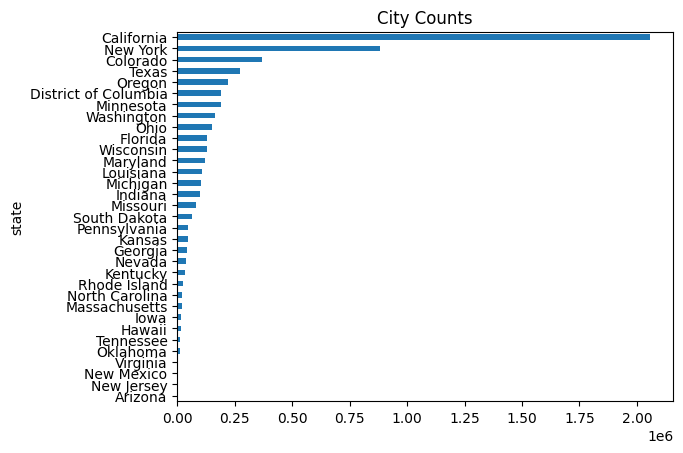

In [24]:
raw_data['state'].value_counts().sort_values().plot(kind='barh', title='City Counts');


In [25]:
raw_data.columns

Index(['address', 'city', 'city_ID', 'common_name', 'condition',
       'diameter_breast_height_CM', 'diameter_breast_height_binned_CM',
       'district', 'elevation', 'greater_metro', 'height_M', 'height_binned_M',
       'latitude_coordinate', 'location_name', 'location_type',
       'longitude_coordinate', 'most_recent_observation',
       'most_recent_observation_type', 'native', 'neighborhood',
       'overhead_utility', 'percent_population', 'planted_date',
       'retired_date', 'scientific_name', 'state', 'tree_ID', 'ward',
       'zipcode'],
      dtype='object')

Select needed features. They have lots of missing values anyways

In [35]:
features_to_drop = ['address', 'diameter_breast_height_binned_CM', 'district', 'city_ID',
                    'height_binned_M','latitude_coordinate', 'location_name', 'location_type',
                    'longitude_coordinate','neighborhood', 'overhead_utility', 'percent_population',
                    'planted_date', 'retired_date', 'scientific_name', 'tree_ID', 'ward', 'zipcode']

selected_features = ['city', 'common_name', 'condition', 'diameter_breast_height_CM', 'greater_metro', 'elevation', 'latitude_coordinate', 'longitude_coordinate',
                     'most_recent_observation', 'most_recent_observation_type', 'native', 'state', 'height_M']

print('Missings per feature')
raw_data[selected_features].isna().sum()

Missings per feature


city                               1899
common_name                      892786
condition                       3038500
diameter_breast_height_CM       2785979
greater_metro                         0
elevation                          6218
latitude_coordinate              751578
longitude_coordinate             751709
most_recent_observation         2127842
most_recent_observation_type    3198777
native                                0
state                                31
height_M                        4951094
dtype: int64

drop the features

In [36]:
print(f'Heights available for training: {raw_data['height_M'].notna().sum()}')

Heights available for training: 709143


In [37]:
data_with_missings = raw_data[selected_features]
data_with_missings.shape

(5660237, 13)

In [38]:
print('missing per feature')
data_with_missings.isna().sum()

missing per feature


city                               1899
common_name                      892786
condition                       3038500
diameter_breast_height_CM       2785979
greater_metro                         0
elevation                          6218
latitude_coordinate              751578
longitude_coordinate             751709
most_recent_observation         2127842
most_recent_observation_type    3198777
native                                0
state                                31
height_M                        4951094
dtype: int64

The above feature's missing values will be replaced by the most frequent values or median values per city.

The date features, `most_recent_observation` and ` most_recent_observation_type` will be treated separately.

In [39]:
data_with_missings[['city', 'state']].sample(15)

,city,state
87438,Denver,Colorado
411611,Los Angeles,California
82433,San Francisco,California
73245,New Orleans,Louisiana
21021,San Jose,California
117995,Washington DC,District of Columbia
28266,Minneapolis,Minnesota
31325,Pittsburgh,Pennsylvania
137869,Columbus,Ohio
212422,San Jose,California


Use coordinates to replace missing cities

In [40]:
 
from tqdm import tqdm
from joblib import Memory

memory = Memory('./cachedir', verbose=0)

@memory.cache
def cache_city_name(lat: float, lon: float):
    return city_mapper.get_city_name(lat, lon)

if not os.path.exists('data_with_missings.parquet'):
    for index, row in tqdm(data_with_missings[data_with_missings['city'].isna()].iterrows(), total=data_with_missings['city'].isna().sum()):
        lat, lon = row['latitude_coordinate'], row['longitude_coordinate']
        if pd.notna(lat) and pd.notna(lon):
            data_with_missings.at[index, 'city'] = cache_city_name(lat, lon)
        else:
            data_with_missings.at[index, 'city'] = pd.NA
else:
    pass

100%|██████████| 1899/1899 [16:04<00:00,  1.97it/s]


Save `data_with_missings` to file for future loading

In [65]:
data_with_missings.loc[:, 'most_recent_observation'] = data_with_missings['most_recent_observation'].astype(str)

if not os.path.exists('data_with_missings.parquet'):
    (data_with_missings.drop(['latitude_coordinate', 'longitude_coordinate'], axis=1)
                       .to_parquet('data_with_missings.parquet', engine='pyarrow', compression='gzip'))
    
    
data_with_missings = pd.read_parquet('data_with_missings.parquet')

In [66]:
data_with_missings[data_with_missings['city'].isna()]

,city,common_name,condition,diameter_breast_height_CM,greater_metro,elevation,most_recent_observation,most_recent_observation_type,native,state,height_M
78,None,White ash,fair,NaN,Albuquerque,1513.0,7/25/2019,inventory_date,introduced,New Mexico,91.86352
270,None,Siberian elm,good,NaN,Albuquerque,1513.0,7/9/2019,inventory_date,introduced,New Mexico,433.07088
538,None,Ash,fair,NaN,Albuquerque,1513.0,7/1/2019,inventory_date,no_info,New Mexico,236.22048
568,None,Cherry plum,poor,NaN,Albuquerque,1513.0,6/27/2019,inventory_date,introduced,New Mexico,45.93176
746,None,None,None,NaN,Albuquerque,1513.0,nan,inventory_date,no_info,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
17274,None,None,None,NaN,Worcester,156.0,nan,None,no_info,Massachusetts,NaN
17275,None,None,None,NaN,Worcester,156.0,nan,None,no_info,Massachusetts,NaN
17276,None,None,None,NaN,Worcester,156.0,nan,None,no_info,Massachusetts,NaN
17277,None,None,None,NaN,Worcester,156.0,nan,None,no_info,Massachusetts,NaN


In [67]:
data_with_missings['city'][data_with_missings['city'].isna()]
data_with_missings['city'].unique()

array(['Albuquerque', None, 'Mānoa', 'Kailua', 'Anaheim',
       'Enchanted Lake', 'Tampa', 'McCully', 'East Honolulu', 'Arlington',
       'Atlanta', 'Decatur', 'EastPoint', 'Unincorporated', 'Hapeville',
       'Scottdale', 'CollegePark', 'AvondaleEstates', 'Dunwoody',
       'Clarkston', 'Brookhaven', 'SandySprings', 'Marietta', 'Chamblee',
       'Tucker', 'Doraville', 'CandlerMcAfee', 'Lithonia', 'Aurora',
       'Austin', 'Baltimore', 'Boston', 'Buffalo', 'Cape Coral',
       'Colorado Springs', 'Columbus', 'Dallas', 'Denver', 'De Soto',
       'Newton', 'Baxter', 'Dexter', 'Van Meter', 'Bayard', 'Earlham',
       'Mitchellville', 'Panora', 'Stuart', 'Milo', 'Adair', 'Hartford',
       'Carlisle', 'Monroe', 'Prairie City', 'Colfax', 'Dallas Center',
       'Guthrie Center', 'Polk City', 'Waukee', 'Runnells', 'Elkhart',
       'Granger', 'Pleasant Hill', 'Oakland Acres', 'Kellogg', 'Woodward',
       'Bouton', 'Union', 'Des Moines', 'Redfield', 'Windsor Heights',
       'Sully', '

In [68]:
city_to_state_dict = data_with_missings.groupby('city')['state'].first().to_dict()


missing_states = data_with_missings['state'].isna()
data_with_missings.loc[missing_states, 'state'] = data_with_missings.loc[missing_states, 'city'].map(city_to_state_dict)


In [74]:
# Confirm missing values again
data_with_missings.isna().sum()

city                                 31
common_name                      892786
condition                       3038500
diameter_breast_height_CM       2785979
greater_metro                         0
elevation                          6218
most_recent_observation               0
most_recent_observation_type    3198777
native                                0
state                                31
height_M                        4951094
dtype: int64

In [81]:
data_with_missings['native'].value_counts()

native
introduced             2982241
naturally_occurring    1398442
no_info                1279523
Name: count, dtype: int64

In [71]:
# Reverse the city_to_state_dict
state_to_city_dict = {v: k for k, v in city_to_state_dict.items()}

# Update missing values in the city column
missing_cities = data_with_missings['city'].isna()
data_with_missings.loc[missing_cities, 'city'] = data_with_missings.loc[missing_cities, 'state'].map(state_to_city_dict)


In [73]:
# Confirm missing values again
data_with_missings.isna().sum()

city                                 31
common_name                      892786
condition                       3038500
diameter_breast_height_CM       2785979
greater_metro                         0
elevation                          6218
most_recent_observation               0
most_recent_observation_type    3198777
native                                0
state                                31
height_M                        4951094
dtype: int64

Drop rows where `city` and `state` contain nans

In [78]:
before_dropping = len(data_with_missings)
print(f'df rows before dropp: {before_dropping}')

data_with_missings.dropna(subset=['city', 'state'], how='all', inplace=True)

print(f'df rows after dropp: {len(data_with_missings)}. Number of rows dropped: {before_dropping - len(data_with_missings)}')


df rows before dropp: 5660237
df rows after dropp: 5660206. Number of rows dropped: 31


In [79]:
data.isna().sum()

address                             17454
city                                    0
city_ID                             17454
common_name                         17454
condition                           17454
diameter_breast_height_CM           17454
diameter_breast_height_binned_CM     2409
district                            17454
elevation                               0
greater_metro                           0
height_M                            17454
height_binned_M                     17454
latitude_coordinate                 17454
location_name                       17454
location_type                       17454
longitude_coordinate                17454
most_recent_observation             17454
most_recent_observation_type        17454
native                                  0
neighborhood                        17454
overhead_utility                    17454
percent_population                  17454
planted_date                        17454
retired_date                      

In [157]:
missing_features = ['common_name', 'condition', 'diameter_breast_height_CM']
missing_dates = ['most_recent_observation', 'most_recent_observation_type']

for feature in missing_features:
    print(f'{feature}: {data_with_missings[feature].unique()}\n\n')

common_name: ['American (basswood) linden' 'Quaking aspen' 'Silver maple' ...
 'Chicagolnd hkbry' 'Oakmongolian' 'Ashflowering']


condition: [nan 'good' 'poor' 'fair' 'dead' 'excellent' 'dead/dying' ' ']


diameter_breast_height_CM: [   nan  58.42  68.58 ...  83.   150.     0.5 ]


state: ['Wisconsin' 'California' 'Texas' 'New York' 'Florida' 'Washington'
 'Colorado' 'Massachusetts' 'Michigan' 'Maryland' 'New Mexico' nan
 'North Carolina' 'Oklahoma' 'Tennessee' 'Missouri' 'Nevada' 'Arizona'
 'Minnesota' 'Indiana' 'Louisiana' 'Ohio' 'Hawaii' 'Virginia' 'New Jersey'
 'Oregon' 'Rhode Island' 'Georgia' 'Pennsylvania' 'Kentucky' 'Kansas'
 'Iowa' 'District of Columbia' 'South Dakota']




In [154]:

# from sklearn.impute import SimpleImputer

# def replace_missings(df, feature):
#     print(f"Before replacing missing values in {feature}: {df[feature].isnull().sum()} missing values.")
    
#     if df[feature].dtype in ['int64', 'float64']:
#         imputer = SimpleImputer(strategy='median')
#     else:
#         imputer = SimpleImputer(strategy='most_frequent')
        
#     impute_group = lambda x: x if x.isnull().all() else imputer.fit_transform(x.values.reshape(-1, 1)).ravel()
    
#     # Group by city and apply the imputer
#     df[feature] = df.groupby('city')[feature].transform(impute_group)
    
#     print(f"After replacing missing values in {feature}: {df[feature].isnull().sum()} missing values.\n")
    
#     return df


# # Replace missing values for each feature in the list
# for feature in missing_features:
#     data = replace_missings(data_with_missings, feature)


Before replacing missing values in common_name: 776776 missing values.
After replacing missing values in common_name: 776776 missing values.

Before replacing missing values in condition: 2398488 missing values.
After replacing missing values in condition: 2398488 missing values.

Before replacing missing values in diameter_breast_height_CM: 2701522 missing values.
After replacing missing values in diameter_breast_height_CM: 2701522 missing values.

Before replacing missing values in state: 1899 missing values.
After replacing missing values in state: 1899 missing values.

